In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from adamw import AdamW
from nadam import Nadam
from uoptim import UOptimizer


from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from utils_exp import plot_graphs

import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH = './fMNIST_data'

In [2]:
train_data = datasets.FashionMNIST(PATH, train=True, download=True, transform=transforms.ToTensor())

# calculate statistics for fashion MNIST
global_norm_mean = train_data.train_data.float().div(255).mean().item()
global_norm_std = train_data.train_data.float().div(255).std().item()

In [3]:
# util to create loaders
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((global_norm_mean,), (global_norm_std,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path=PATH):
    test_data = datasets.FashionMNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [4]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [5]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [7]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='UAdam', **optim_params):
        super(Net, self).__init__()
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        elif optim_type == 'AdamW':
            self.optim = AdamW(self.parameters(), **optim_params)
        elif optim_type == 'Nadam':
            self.optim = Nadam(self.parameters(), **optim_params)
        elif optim_type == 'Adamax':
            self.optim = optim.Adamax(self.parameters(), **optim_params)
        elif optim_type == 'UOptimizer':
            self.optim = UOptimizer(params = self.parameters(), **optim_params)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [8]:
models = {
          # testing correctness of SGD
          'SGD': Net(True, False, 'SGD', lr=1e-3).to(device), 
          'UOSGD': Net(True, False, 'UOptimizer', lr=1e-3).to(device), 
    
          'SGD_momentum':Net(True, False, 'SGD', momentum=0.9, lr=1e-3).to(device),
          'UOSGD_momentum':Net(True, False, 'UOptimizer', use_exp_avg_norm = True, beta1_dump=0, lr=1e-3).to(device),
    
          'SGD_momentum_n':Net(True, False, 'SGD', momentum=0.9, nesterov=True,  lr=1e-3).to(device),
          'UOSGD_momentum_n':Net(True, False, 'UOptimizer', use_exp_avg_norm = True, beta1_dump=0,
                                 exp_avg_norm_type='nesterov', lr=1e-3).to(device),
    
          # testing RMSProp      
          'RMSProp': Net(True, False, 'RMSProp', lr=1e-4).to(device), 
          'UORMSProp': Net(True, False, 'UOptimizer', use_exp_avg_sq_norm = True,  lr=1e-4).to(device), 
          
          # testing Adadelta
          'Adadelta':Net(True, False, 'Adadelta', lr=1).to(device),
          'UOAdadelta':Net(True, False, 'UOptimizer', use_exp_avg_sq_norm = True, use_adadelta_lr=True, lr=1).to(device),
            
          # testing adam-like algoritms. 
          'Adam': Net(True, False, 'Adam', lr=1e-4).to(device), 
          'UOAdam': Net(True, False, 'UOptimizer', use_exp_avg_norm=True, 
                        use_exp_avg_sq_norm = True, use_bias_correction= True, lr=1e-4).to(device), 
    
          'Amsgrad':Net(True, False, 'Adam', lr=1e-4, amsgrad=True).to(device),
          'UOAmsgrad':Net(True, False, 'UOptimizer', use_exp_avg_norm=True, use_exp_avg_sq_norm = True, 
                            use_bias_correction=True, exp_avg_sq_norm_type='max_past_sq', lr=1e-4).to(device), 
          
          # AdamW is not included in Pytorch, so I used fastai implementation from here:
          # https://github.com/anandsaha/fastai.part1.v2/commit/159e1712e60f299e11c42caab35c726f367bcd61
          'AdamW':Net(True, False, 'AdamW', lr=1e-4, weight_decay=0.00025).to(device),
          'UOAdamW':Net(True, False, 'UOptimizer', use_exp_avg_norm=True, use_exp_avg_sq_norm = True, 
                        use_bias_correction= True, decouple_wd=True, lr=1e-4, weight_decay=0.00025).to(device),
    
          # Please note that pytorch Nadam is the official Nadam implementation for Keras translated to PyTorch
          # I use the classical Nadam formulas, so the results could be differ
          'Nadam':Net(True, False, 'Nadam', lr=1e-4).to(device),
          'UONadam':Net(True, False, 'UOptimizer', use_exp_avg_norm=True, use_exp_avg_sq_norm = True, 
                            use_bias_correction= True,exp_avg_norm_type='nesterov',  lr=1e-4).to(device),
          
          'Adamax':Net(True, False, 'Adamax', lr=1e-4).to(device),
          'UOAdamax':Net(True, False, 'UOptimizer', use_exp_avg_norm=True, use_exp_avg_sq_norm = True, 
                        use_bias_correction= True, exp_avg_sq_norm_type ='infinite_l', lr=1e-4).to(device),
    
    
          # create exotic combinations for fun
          'Adam_with_adadelta_coeff':Net(True, False, 'UOptimizer', 
                                         use_exp_avg_norm = True,
                                         use_exp_avg_sq_norm = True,
                                         use_adadelta_lr = True,
                                         use_bias_correction = True,
                                         lr=1).to(device),
          'Adam_with_exp_avg_norm_like_sgd':Net(True, False, 'UOptimizer', 
                                         use_exp_avg_norm = True,
                                         use_exp_avg_sq_norm = True,
                                         use_bias_correction = True,
                                         beta1_dump=0,
                                         lr=1e-4).to(device),                  
            }
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

You are using the AdamW optimizer


In [9]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [10]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [11]:
n_epoch = 20
for epoch in range(1, n_epoch+1):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses SGD: 2.3055 UOSGD: 2.3331 SGD_momentum: 2.2650 UOSGD_momentum: 2.3088 SGD_momentum_n: 2.3923 UOSGD_momentum_n: 2.3210 RMSProp: 2.3929 UORMSProp: 2.3134 Adadelta: 2.3524 UOAdadelta: 2.3158 Adam: 2.3431 UOAdam: 2.3603 Amsgrad: 2.3278 UOAmsgrad: 2.2936 AdamW: 2.3900 UOAdamW: 2.3504 Nadam: 2.3341 UONadam: 2.3312 Adamax: 2.4368 UOAdamax: 2.3313 Adam_with_adadelta_coeff: 2.2951 Adam_with_exp_avg_norm_like_sgd: 2.3028
Train Epoch: 1 [10000/50000 (20%)]	Losses SGD: 2.1415 UOSGD: 2.1649 SGD_momentum: 1.3033 UOSGD_momentum: 1.2718 SGD_momentum_n: 1.5779 UOSGD_momentum_n: 1.4145 RMSProp: 1.5791 UORMSProp: 1.1623 Adadelta: 0.8756 UOAdadelta: 0.6943 Adam: 1.8413 UOAdam: 1.7487 Amsgrad: 1.7256 UOAmsgrad: 1.7736 AdamW: 1.8242 UOAdamW: 1.7722 Nadam: 1.1519 UONadam: 1.7702 Adamax: 2.0644 UOAdamax: 2.0102 Adam_with_adadelta_coeff: 1.5507 Adam_with_exp_avg_norm_like_sgd: 0.7730
Train Epoch: 1 [20000/50000 (40%)]	Losses SGD: 1.9957 UOSGD: 2.0417 SGD_momentum: 0.9846 UO

Train Epoch: 3 [0/50000 (0%)]	Losses SGD: 1.3824 UOSGD: 1.4261 SGD_momentum: 0.6498 UOSGD_momentum: 0.6205 SGD_momentum_n: 0.6644 UOSGD_momentum_n: 0.6345 RMSProp: 0.7131 UORMSProp: 0.6435 Adadelta: 0.5647 UOAdadelta: 0.4328 Adam: 0.7229 UOAdam: 0.7120 Amsgrad: 0.7282 UOAmsgrad: 0.7151 AdamW: 0.9025 UOAdamW: 0.8739 Nadam: 0.6931 UONadam: 0.6854 Adamax: 0.9970 UOAdamax: 0.9552 Adam_with_adadelta_coeff: 0.5577 Adam_with_exp_avg_norm_like_sgd: 0.4969
Train Epoch: 3 [10000/50000 (20%)]	Losses SGD: 1.2383 UOSGD: 1.2942 SGD_momentum: 0.3935 UOSGD_momentum: 0.4052 SGD_momentum_n: 0.4121 UOSGD_momentum_n: 0.4090 RMSProp: 0.4974 UORMSProp: 0.4311 Adadelta: 0.2467 UOAdadelta: 0.2477 Adam: 0.5118 UOAdam: 0.4917 Amsgrad: 0.4973 UOAmsgrad: 0.5211 AdamW: 0.7690 UOAdamW: 0.7362 Nadam: 0.5022 UONadam: 0.5191 Adamax: 0.8085 UOAdamax: 0.7647 Adam_with_adadelta_coeff: 0.3474 Adam_with_exp_avg_norm_like_sgd: 0.2312
Train Epoch: 3 [20000/50000 (40%)]	Losses SGD: 1.2945 UOSGD: 1.3167 SGD_momentum: 0.6565 UO

Train Epoch: 5 [0/50000 (0%)]	Losses SGD: 1.0559 UOSGD: 1.0290 SGD_momentum: 0.3359 UOSGD_momentum: 0.3893 SGD_momentum_n: 0.3822 UOSGD_momentum_n: 0.3734 RMSProp: 0.4052 UORMSProp: 0.3861 Adadelta: 0.2082 UOAdadelta: 0.1771 Adam: 0.4239 UOAdam: 0.4053 Amsgrad: 0.4345 UOAmsgrad: 0.4386 AdamW: 0.7319 UOAdamW: 0.6962 Nadam: 0.5477 UONadam: 0.4222 Adamax: 0.6181 UOAdamax: 0.6048 Adam_with_adadelta_coeff: 0.2638 Adam_with_exp_avg_norm_like_sgd: 0.2250
Train Epoch: 5 [10000/50000 (20%)]	Losses SGD: 0.9531 UOSGD: 0.9257 SGD_momentum: 0.4130 UOSGD_momentum: 0.3762 SGD_momentum_n: 0.3871 UOSGD_momentum_n: 0.4097 RMSProp: 0.4066 UORMSProp: 0.3828 Adadelta: 0.1872 UOAdadelta: 0.2092 Adam: 0.4252 UOAdam: 0.4533 Amsgrad: 0.4438 UOAmsgrad: 0.4314 AdamW: 0.6810 UOAdamW: 0.6581 Nadam: 0.5247 UONadam: 0.4712 Adamax: 0.6097 UOAdamax: 0.5803 Adam_with_adadelta_coeff: 0.3456 Adam_with_exp_avg_norm_like_sgd: 0.2610
Train Epoch: 5 [20000/50000 (40%)]	Losses SGD: 0.9381 UOSGD: 0.9349 SGD_momentum: 0.4824 UO

Train Epoch: 7 [0/50000 (0%)]	Losses SGD: 0.6367 UOSGD: 0.6361 SGD_momentum: 0.1883 UOSGD_momentum: 0.1732 SGD_momentum_n: 0.1880 UOSGD_momentum_n: 0.1937 RMSProp: 0.2109 UORMSProp: 0.2020 Adadelta: 0.0969 UOAdadelta: 0.0980 Adam: 0.2092 UOAdam: 0.2132 Amsgrad: 0.2161 UOAmsgrad: 0.2317 AdamW: 0.5393 UOAdamW: 0.5336 Nadam: 0.3802 UONadam: 0.2277 Adamax: 0.3992 UOAdamax: 0.3584 Adam_with_adadelta_coeff: 0.1665 Adam_with_exp_avg_norm_like_sgd: 0.0671
Train Epoch: 7 [10000/50000 (20%)]	Losses SGD: 0.9459 UOSGD: 0.9011 SGD_momentum: 0.4529 UOSGD_momentum: 0.4634 SGD_momentum_n: 0.4292 UOSGD_momentum_n: 0.4495 RMSProp: 0.4815 UORMSProp: 0.4702 Adadelta: 0.2248 UOAdadelta: 0.2437 Adam: 0.4659 UOAdam: 0.4606 Amsgrad: 0.4796 UOAmsgrad: 0.4794 AdamW: 0.7807 UOAdamW: 0.7565 Nadam: 0.6160 UONadam: 0.5137 Adamax: 0.6500 UOAdamax: 0.6067 Adam_with_adadelta_coeff: 0.3861 Adam_with_exp_avg_norm_like_sgd: 0.2435
Train Epoch: 7 [20000/50000 (40%)]	Losses SGD: 0.8204 UOSGD: 0.8072 SGD_momentum: 0.4436 UO

Train Epoch: 9 [0/50000 (0%)]	Losses SGD: 0.7748 UOSGD: 0.7719 SGD_momentum: 0.2792 UOSGD_momentum: 0.2920 SGD_momentum_n: 0.2797 UOSGD_momentum_n: 0.2762 RMSProp: 0.3430 UORMSProp: 0.3118 Adadelta: 0.1301 UOAdadelta: 0.0988 Adam: 0.3073 UOAdam: 0.2952 Amsgrad: 0.3611 UOAmsgrad: 0.3382 AdamW: 0.7170 UOAdamW: 0.7090 Nadam: 0.5794 UONadam: 0.3347 Adamax: 0.5272 UOAdamax: 0.5321 Adam_with_adadelta_coeff: 0.2105 Adam_with_exp_avg_norm_like_sgd: 0.1361
Train Epoch: 9 [10000/50000 (20%)]	Losses SGD: 0.7245 UOSGD: 0.7057 SGD_momentum: 0.2098 UOSGD_momentum: 0.2097 SGD_momentum_n: 0.2424 UOSGD_momentum_n: 0.2204 RMSProp: 0.2254 UORMSProp: 0.2217 Adadelta: 0.0415 UOAdadelta: 0.0595 Adam: 0.2157 UOAdam: 0.2143 Amsgrad: 0.2466 UOAmsgrad: 0.2829 AdamW: 0.6199 UOAdamW: 0.6055 Nadam: 0.4636 UONadam: 0.2139 Adamax: 0.4154 UOAdamax: 0.4036 Adam_with_adadelta_coeff: 0.1530 Adam_with_exp_avg_norm_like_sgd: 0.0898
Train Epoch: 9 [20000/50000 (40%)]	Losses SGD: 0.6727 UOSGD: 0.6733 SGD_momentum: 0.3156 UO

Train Epoch: 11 [0/50000 (0%)]	Losses SGD: 0.5375 UOSGD: 0.5825 SGD_momentum: 0.2665 UOSGD_momentum: 0.2733 SGD_momentum_n: 0.2966 UOSGD_momentum_n: 0.3021 RMSProp: 0.2952 UORMSProp: 0.2816 Adadelta: 0.0813 UOAdadelta: 0.1172 Adam: 0.2806 UOAdam: 0.2665 Amsgrad: 0.2995 UOAmsgrad: 0.3482 AdamW: 0.6038 UOAdamW: 0.5954 Nadam: 0.4907 UONadam: 0.3074 Adamax: 0.4070 UOAdamax: 0.4125 Adam_with_adadelta_coeff: 0.2089 Adam_with_exp_avg_norm_like_sgd: 0.0509
Train Epoch: 11 [10000/50000 (20%)]	Losses SGD: 0.7709 UOSGD: 0.7697 SGD_momentum: 0.4367 UOSGD_momentum: 0.5153 SGD_momentum_n: 0.4508 UOSGD_momentum_n: 0.4838 RMSProp: 0.5019 UORMSProp: 0.4296 Adadelta: 0.1697 UOAdadelta: 0.3295 Adam: 0.4573 UOAdam: 0.4662 Amsgrad: 0.5193 UOAmsgrad: 0.4796 AdamW: 0.7587 UOAdamW: 0.7591 Nadam: 0.6145 UONadam: 0.5301 Adamax: 0.5613 UOAdamax: 0.5715 Adam_with_adadelta_coeff: 0.3856 Adam_with_exp_avg_norm_like_sgd: 0.2675
Train Epoch: 11 [20000/50000 (40%)]	Losses SGD: 0.7533 UOSGD: 0.7280 SGD_momentum: 0.3212

Train Epoch: 13 [0/50000 (0%)]	Losses SGD: 0.5559 UOSGD: 0.5698 SGD_momentum: 0.2003 UOSGD_momentum: 0.2070 SGD_momentum_n: 0.2146 UOSGD_momentum_n: 0.1930 RMSProp: 0.2006 UORMSProp: 0.2026 Adadelta: 0.0824 UOAdadelta: 0.1240 Adam: 0.1980 UOAdam: 0.2171 Amsgrad: 0.2318 UOAmsgrad: 0.2221 AdamW: 0.6104 UOAdamW: 0.6124 Nadam: 0.4556 UONadam: 0.1995 Adamax: 0.3285 UOAdamax: 0.3308 Adam_with_adadelta_coeff: 0.1691 Adam_with_exp_avg_norm_like_sgd: 0.0987
Train Epoch: 13 [10000/50000 (20%)]	Losses SGD: 0.6605 UOSGD: 0.6355 SGD_momentum: 0.2837 UOSGD_momentum: 0.2843 SGD_momentum_n: 0.3485 UOSGD_momentum_n: 0.3077 RMSProp: 0.3183 UORMSProp: 0.2726 Adadelta: 0.2713 UOAdadelta: 0.2412 Adam: 0.3282 UOAdam: 0.2943 Amsgrad: 0.3281 UOAmsgrad: 0.3191 AdamW: 0.7019 UOAdamW: 0.6936 Nadam: 0.5595 UONadam: 0.2867 Adamax: 0.4249 UOAdamax: 0.4470 Adam_with_adadelta_coeff: 0.2601 Adam_with_exp_avg_norm_like_sgd: 0.1595
Train Epoch: 13 [20000/50000 (40%)]	Losses SGD: 0.4873 UOSGD: 0.4841 SGD_momentum: 0.1877

Train Epoch: 15 [0/50000 (0%)]	Losses SGD: 0.5881 UOSGD: 0.5936 SGD_momentum: 0.3489 UOSGD_momentum: 0.3628 SGD_momentum_n: 0.3831 UOSGD_momentum_n: 0.3419 RMSProp: 0.3782 UORMSProp: 0.3552 Adadelta: 0.2574 UOAdadelta: 0.2029 Adam: 0.3408 UOAdam: 0.3598 Amsgrad: 0.3632 UOAmsgrad: 0.3545 AdamW: 0.6871 UOAdamW: 0.6840 Nadam: 0.5509 UONadam: 0.3453 Adamax: 0.4171 UOAdamax: 0.4234 Adam_with_adadelta_coeff: 0.3188 Adam_with_exp_avg_norm_like_sgd: 0.3539
Train Epoch: 15 [10000/50000 (20%)]	Losses SGD: 0.7428 UOSGD: 0.7313 SGD_momentum: 0.3591 UOSGD_momentum: 0.4043 SGD_momentum_n: 0.4205 UOSGD_momentum_n: 0.3796 RMSProp: 0.3568 UORMSProp: 0.3685 Adadelta: 0.2107 UOAdadelta: 0.1420 Adam: 0.3722 UOAdam: 0.3391 Amsgrad: 0.3813 UOAmsgrad: 0.4368 AdamW: 0.8184 UOAdamW: 0.8066 Nadam: 0.6643 UONadam: 0.3515 Adamax: 0.5397 UOAdamax: 0.4971 Adam_with_adadelta_coeff: 0.3206 Adam_with_exp_avg_norm_like_sgd: 0.0982
Train Epoch: 15 [20000/50000 (40%)]	Losses SGD: 0.5881 UOSGD: 0.6031 SGD_momentum: 0.2741

Train Epoch: 17 [0/50000 (0%)]	Losses SGD: 0.5870 UOSGD: 0.5956 SGD_momentum: 0.2526 UOSGD_momentum: 0.2678 SGD_momentum_n: 0.2343 UOSGD_momentum_n: 0.2753 RMSProp: 0.2989 UORMSProp: 0.2948 Adadelta: 0.0680 UOAdadelta: 0.1061 Adam: 0.2546 UOAdam: 0.2559 Amsgrad: 0.2935 UOAmsgrad: 0.3000 AdamW: 0.6687 UOAdamW: 0.6747 Nadam: 0.5281 UONadam: 0.3004 Adamax: 0.3951 UOAdamax: 0.4025 Adam_with_adadelta_coeff: 0.2158 Adam_with_exp_avg_norm_like_sgd: 0.0966
Train Epoch: 17 [10000/50000 (20%)]	Losses SGD: 0.5846 UOSGD: 0.5967 SGD_momentum: 0.2480 UOSGD_momentum: 0.2867 SGD_momentum_n: 0.2471 UOSGD_momentum_n: 0.2364 RMSProp: 0.2603 UORMSProp: 0.2301 Adadelta: 0.1252 UOAdadelta: 0.1492 Adam: 0.2369 UOAdam: 0.2913 Amsgrad: 0.3265 UOAmsgrad: 0.2755 AdamW: 0.6685 UOAdamW: 0.6639 Nadam: 0.5605 UONadam: 0.2592 Adamax: 0.3434 UOAdamax: 0.3690 Adam_with_adadelta_coeff: 0.2093 Adam_with_exp_avg_norm_like_sgd: 0.1309
Train Epoch: 17 [20000/50000 (40%)]	Losses SGD: 0.6092 UOSGD: 0.6161 SGD_momentum: 0.3281

Train Epoch: 19 [0/50000 (0%)]	Losses SGD: 0.5739 UOSGD: 0.5867 SGD_momentum: 0.3848 UOSGD_momentum: 0.4071 SGD_momentum_n: 0.4145 UOSGD_momentum_n: 0.4114 RMSProp: 0.4220 UORMSProp: 0.4139 Adadelta: 0.1403 UOAdadelta: 0.2859 Adam: 0.4089 UOAdam: 0.3407 Amsgrad: 0.4307 UOAmsgrad: 0.4282 AdamW: 0.7213 UOAdamW: 0.7074 Nadam: 0.5821 UONadam: 0.4429 Adamax: 0.4454 UOAdamax: 0.4439 Adam_with_adadelta_coeff: 0.3540 Adam_with_exp_avg_norm_like_sgd: 0.1786
Train Epoch: 19 [10000/50000 (20%)]	Losses SGD: 0.7155 UOSGD: 0.7525 SGD_momentum: 0.3778 UOSGD_momentum: 0.4089 SGD_momentum_n: 0.3300 UOSGD_momentum_n: 0.3919 RMSProp: 0.3753 UORMSProp: 0.3335 Adadelta: 0.0939 UOAdadelta: 0.1193 Adam: 0.3459 UOAdam: 0.3495 Amsgrad: 0.3900 UOAmsgrad: 0.3734 AdamW: 0.8222 UOAdamW: 0.8318 Nadam: 0.6839 UONadam: 0.3151 Adamax: 0.4636 UOAdamax: 0.4568 Adam_with_adadelta_coeff: 0.2969 Adam_with_exp_avg_norm_like_sgd: 0.1856
Train Epoch: 19 [20000/50000 (40%)]	Losses SGD: 0.4506 UOSGD: 0.4482 SGD_momentum: 0.1730

## Visual results

#### Loss

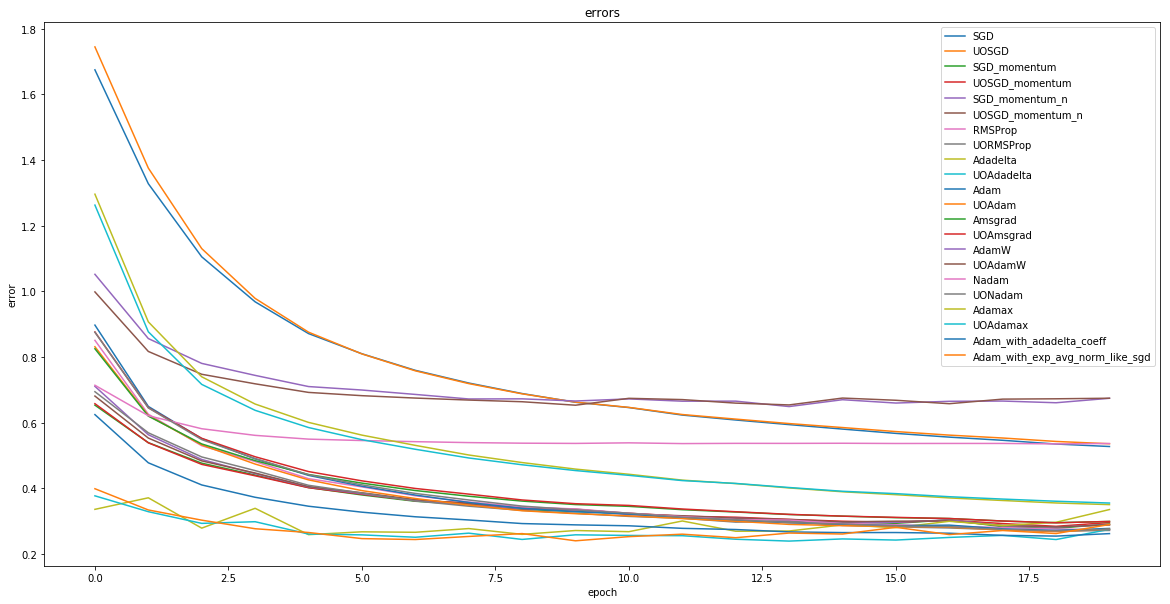

In [12]:
plot_graphs(test_log, 'loss', fs=(20, 10))

- Below we make a pairwise comparaison of standard algorithms and my implementation. Please note, that due to stochastic nature
of algorithms, the descent path could differ, but not too much. Exception for Nadam. For comparaison I use official implementation for Keras and it contains some hardcoded parameters that could not fit to any dataset. My implementation more classical and in case of this dataset looks better that Keras variant. 
- For better visualisation I excluded first 5 epochs, so below are the results from 6th epoch

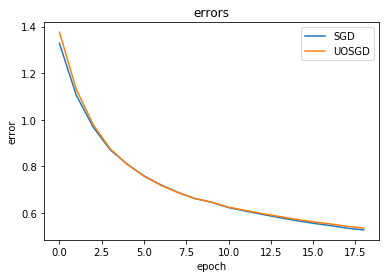

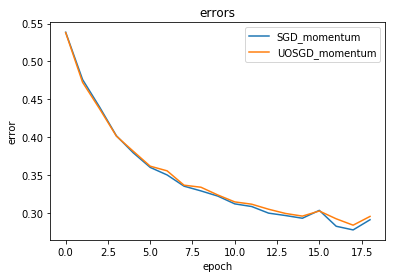

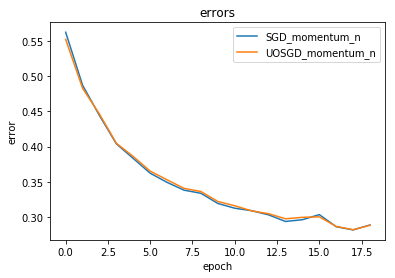

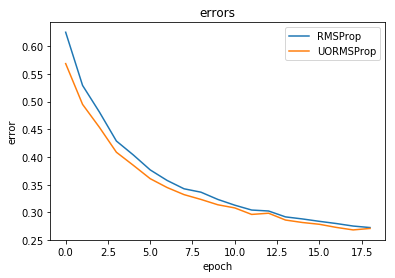

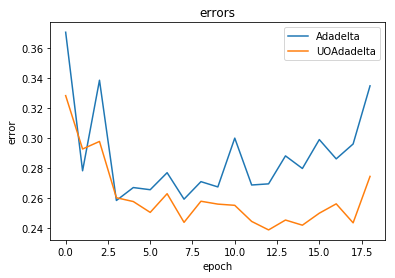

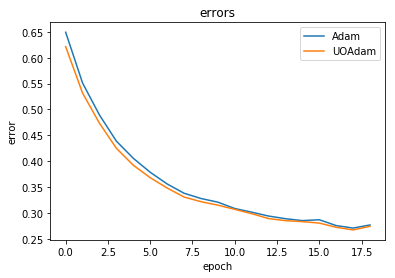

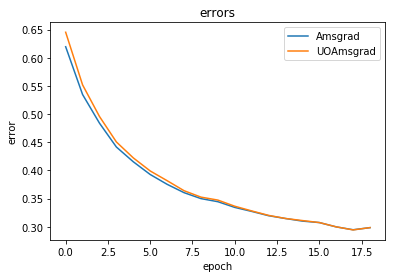

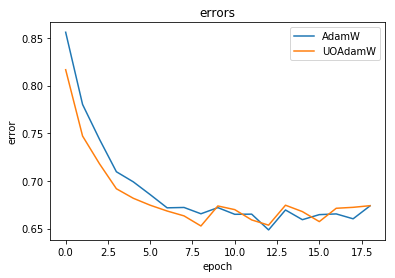

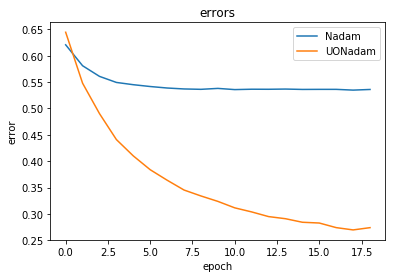

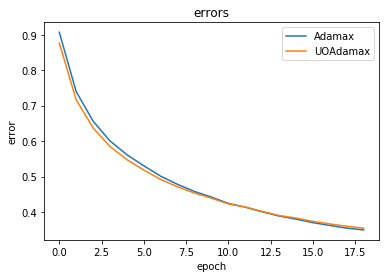

In [13]:
for i in ['SGD', 'SGD_momentum', 'SGD_momentum_n', 'RMSProp', 'Adadelta', 'Adam', 'Amsgrad', 'AdamW', 'Nadam', 'Adamax']:
    new_test_log = {}
    for k, v in test_log.items():
        if k == 'UO'+i or k==i:
            new_test_log[k] = v[1:]
    plot_graphs(new_test_log, 'loss')

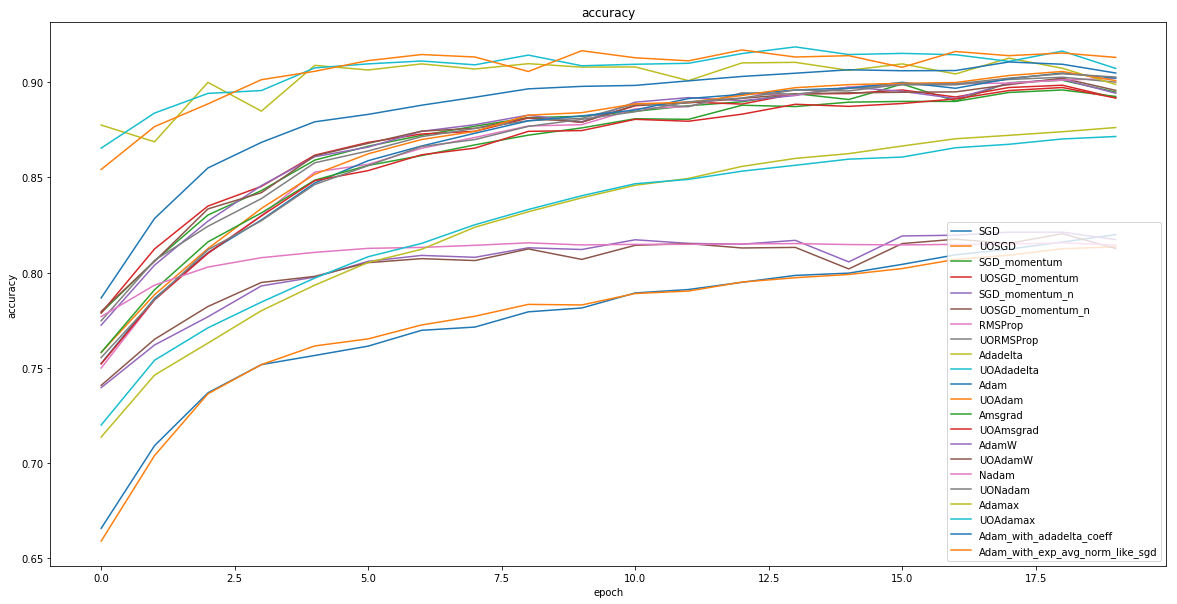

In [14]:
plot_graphs(test_log, 'accuracy', fs = (20, 10))

Now analyze dynamic of standard algorithms (we excluded the worst algos here like SGD, AdamW and Nadam). It looks like the best it is RMSProp here

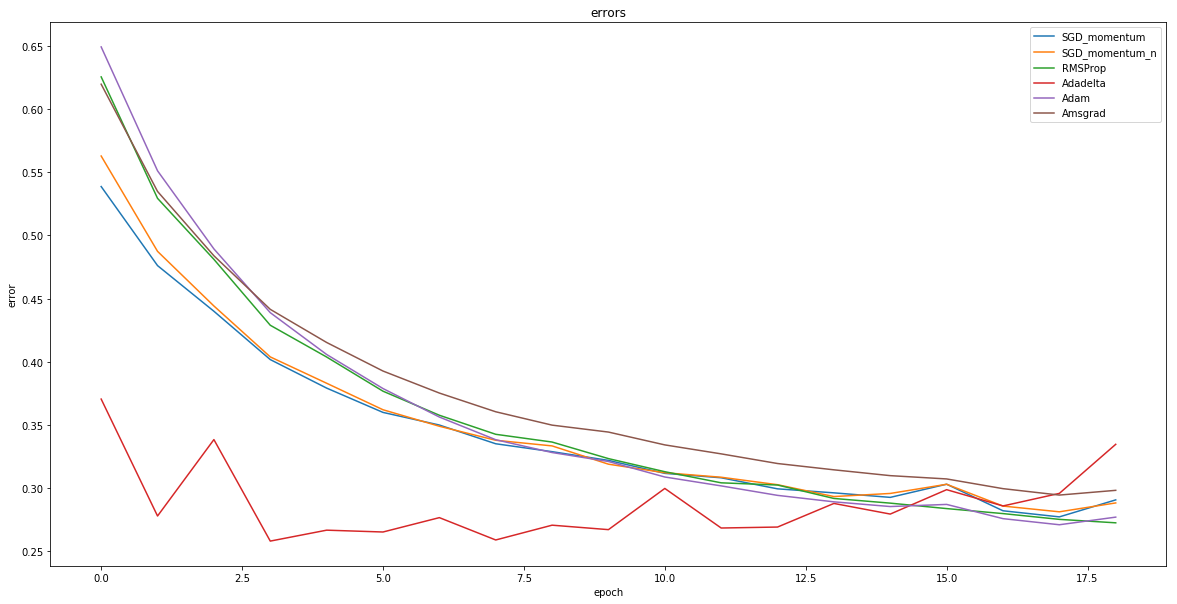

In [23]:
new_test_log = {}
for i in ['SGD_momentum', 'SGD_momentum_n', 'RMSProp', 'Adadelta', 'Adam', 'Amsgrad']:
    for k, v in test_log.items():
        if  k==i:
            new_test_log[k] = v[1:]
plot_graphs(new_test_log, 'loss', fs = (20, 10))

Lets compare RMSProp with the exotic combinations of our algorithm. **It looks like our exotic combinations provided better results that the best standard algoritm**

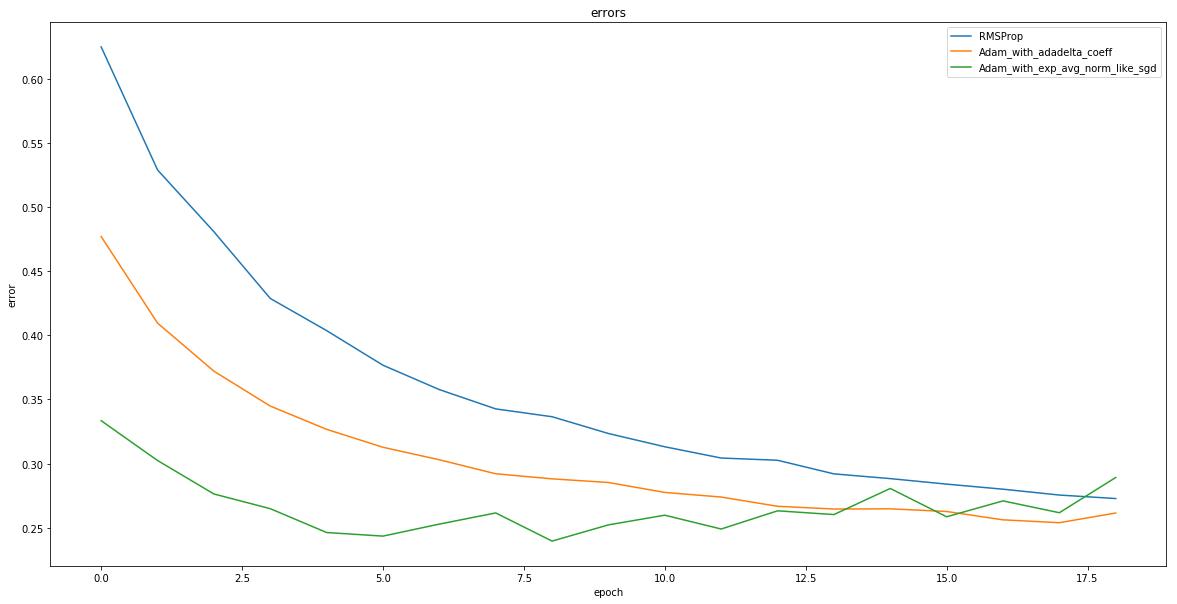

In [24]:
new_test_log = {}
for i in ['RMSProp','Adam_with_adadelta_coeff', 'Adam_with_exp_avg_norm_like_sgd']:
    for k, v in test_log.items():
        if  k==i:
            new_test_log[k] = v[1:]
plot_graphs(new_test_log, 'loss', fs = (20, 10))